# Price Prediciton Models Part 3: Ranks

Instead of using a trained/untrained model, or using elements of style transfer, we try using a classifier with many classes as our "ranks". Each rank will be mapped to some value, and the distribution of those values will match the distribution of the prices in our labels.

### TLDR

After applying a model wrapper in order to use the same loss function as the other models, we are able to compare their perfermances by comparing their test losses. 

Using 50 classes, the test loss after just training for 10 epochs is, in terms of MSELoss, about 1.0, which is a lot better than the 1.16 of the other models.

This model also provides another metric for performance gauging. The accuracy of this model is around 9%, which is not very good. However it shows that if we use our previous models on the same classification task, they would have done even worse. So the overall accuracy of our models so far is not very good.

With some randomness added to the final layer of the wrapper model, we can simulate a continuous output.

## Classes

In [1]:
import torch, torchvision, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torchvision.transforms as transforms, torchvision.models as models
import matplotlib.pyplot as plt
import PIL, IPython
import pathlib
import pandas as pd
import math
import random
from tqdm.auto import tqdm
from collections import OrderedDict
#plt.style.use('dark_background')
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda')

In [4]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [5]:
labels = pd.read_csv(dataset_dir + 'all_labels.csv')

### Some Data Visualization

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 7 Text major ticklabel objects>)

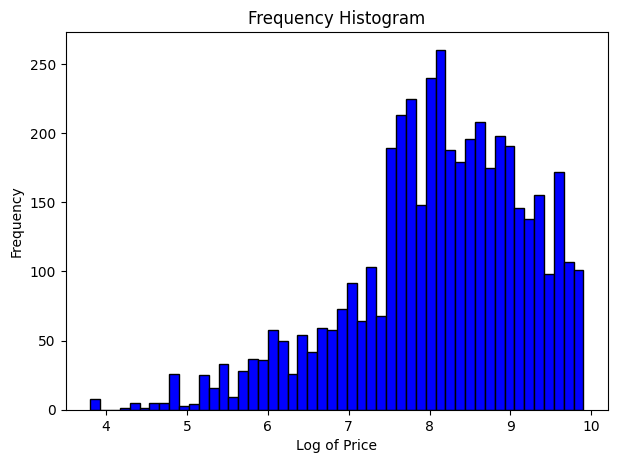

In [ ]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
p = labels.apply(lambda row: math.log(row['price']), axis=1)
plt.hist(p, bins=50, color='b', lw=1, ec='k')
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', facecolor='w')
plt.ylabel('Frequency', color='k')
plt.xlabel('Log of Price', color='k')
plt.xticks(color='k')
plt.yticks(color='k')



(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 9 Text major ticklabel objects>)

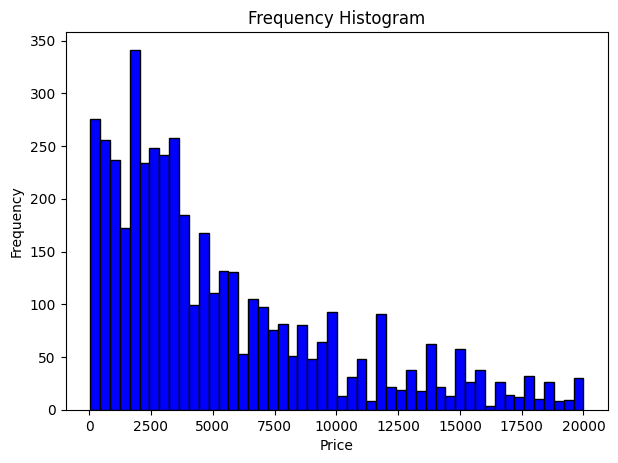

In [ ]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
p1 = labels['price']
plt.hist(p1, bins=50, color='b', lw=1, ec='k')
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', facecolor='w')
plt.ylabel('Frequency', color='k')
plt.xlabel('Price', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


### Making Classes

We would want to have many classes, to simulate having continuous output values.  
And we would want our data to be evenly distributed in those classes.

In [ ]:
classes = pd.DataFrame(columns=['price', 'index'])
sorted = labels.sort_values(by=['price'])
sorted = sorted.reset_index()
print(sorted.head())
last_one = 0
add_amt = 35
for i in range(0, 50):
  index = math.floor(i/50.0 * sorted['price'].size)
  class_ = sorted['price'][index]
  # This step prevents the difference of two classes from being too small
  # + 35 seems to yield the lowest SD (see classes bar graph below)
  while (class_ <= last_one + add_amt): 
    index += 1
    class_ = sorted['price'][index]

  last_one = class_
  classes = classes.append({'price' : class_, 'index': index}, ignore_index=True)

print(classes)




   index  Unnamed: 0            name  price
0   3560        3560  artsy_2596.jpg   45.0
1   3515        3515  artsy_2551.jpg   45.0
2   3904        3904  artsy_2946.jpg   45.0
3   3476        3476  artsy_2510.jpg   45.0
4   3861        3861  artsy_2903.jpg   45.0
       price   index
0      45.00     0.0
1     200.00    90.0
2     340.63   180.0
3     444.00   270.0
4     553.00   361.0
5     700.00   451.0
6     850.00   541.0
7    1000.00   632.0
8    1200.00   722.0
9    1350.00   812.0
10   1521.11   903.0
11   1755.00   993.0
12   1843.00  1083.0
13   1966.00  1174.0
14   2006.00  1275.0
15   2200.00  1354.0
16   2349.20  1445.0
17   2500.00  1535.0
18   2574.00  1625.0
19   2757.44  1716.0
20   2950.00  1806.0
21   3000.00  1896.0
22   3200.00  1987.0
23   3400.00  2077.0
24   3500.00  2167.0
25   3600.00  2258.0
26   3876.18  2348.0
27   4000.00  2438.0
28   4346.02  2528.0
29   4500.00  2619.0
30   4810.00  2709.0
31   5050.78  2799.0
32   5500.00  2890.0
33   5790.62  2980.0
3

#### Price distribution
As shown below, our data can be more or less evenly distributed in our classes. This helps training more effectively and our classes can represent the distribution of prices in real life.

(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500., 20000.]), <a list of 10 Text major ticklabel objects>)

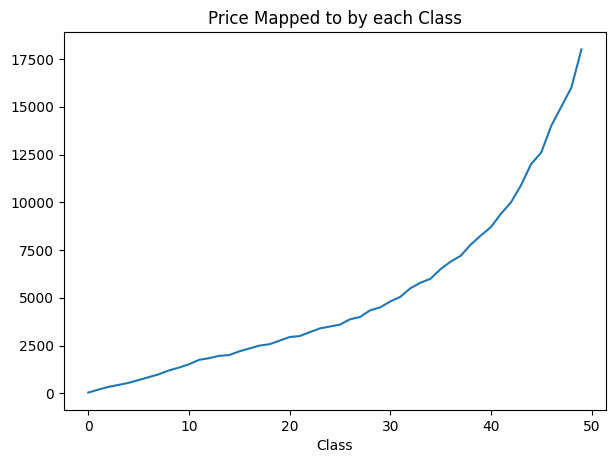

In [ ]:
classes['price'].plot()
plt.gca().set( title='Price Mapped to by each Class', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')
#plt.xlim([0, 20000])

(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500., 20000., 22500.]), <a list of 11 Text major ticklabel objects>)

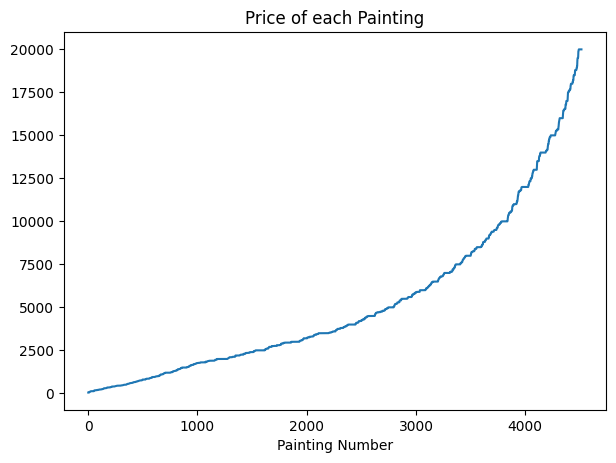

In [ ]:
sorted['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price of each Painting', facecolor='w')
plt.xlabel('Painting Number', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


In [ ]:
print(classes['price'][0])
print(classes['price'][49])

45.0
18000.0


In [ ]:
# Analyze the distribution of our data in these classes
classes_hist = np.zeros(50)
indices = np.zeros(50)
for i in range(1, 50):
  indices[i] = indices[i - 1] + 1

for p in labels['price']:
  for i in range(0, 49):
    if (p >= classes['price'][i] and p < classes['price'][i + 1]): 
      classes_hist[i] += 1
  if (p >= classes['price'][49]):
    classes_hist[49] += 1

print(classes_hist)
print(classes_hist.sum())
print(sorted['price'].size)
print(f"""
Average: {np.average(classes_hist)}
Variance: {np.var(classes_hist)}
SD: {np.std(classes_hist)}
Median: {np.median(classes_hist)}
Max: {np.max(classes_hist)}
Min: {np.min(classes_hist)}
""")



[ 84.  90.  92.  94.  88.  89.  95.  73. 106.  91.  89.  84.  98. 102.
  73.  95.  91.  91.  76. 105.  57. 110.  96.  49. 123. 106.  34. 147.
  40. 141.  89.  74. 107.  59. 118.  95.  83.  98.  88.  92.  80.  96.
  95.  88.  90.  78.  94.  82. 103.  98.]
4516.0
4516

Average: 90.32
Variance: 414.0976
SD: 20.34938819719158
Median: 91.0
Max: 147.0
Min: 34.0



[Text(0.5, 1.0, 'Distribution of data in classes')]

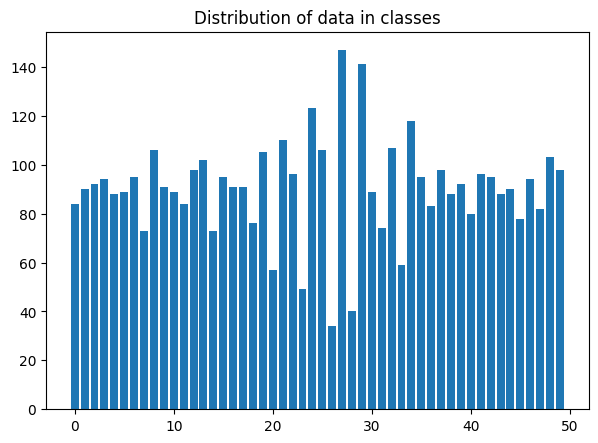

In [ ]:
plt.bar(indices,classes_hist)
plt.gca().set( title='Distribution of data in classes')

In [ ]:
# Some more manual intervention to even out the distribution
classes_2 = classes.copy()
for i in range (0, 48):
  if (classes_hist[i] * 1.3 < classes_hist[i+1]):
    classes_2['index'][i+1] = math.floor(classes['index'][i+1] + (classes['index'][i+2] - classes['index'][i+1]) * 1/5)
    classes_2['price'][i+1] = sorted['price'][classes_2['index'][i+1]]


classes_hist_2 = np.zeros(50)

for p in labels['price']:
  for i in range(0, 49):
    if (p >= classes_2['price'][i] and p < classes_2['price'][i + 1]): 
      classes_hist_2[i] += 1
  if (p >= classes_2['price'][49]):
    classes_hist_2[49] += 1

print(classes_hist_2)
print(classes_hist_2.sum())
print(sorted['price'].size)
print(f"""
Average: {np.average(classes_hist_2)}
Variance: {np.var(classes_hist_2)}
SD: {np.std(classes_hist_2)}
Median: {np.median(classes_hist_2)}
Max: {np.max(classes_hist_2)}
Min: {np.min(classes_hist_2)}
""")


[ 84.  90.  92.  94.  88.  89.  95.  73. 106.  91.  89.  84.  98. 102.
  73.  95.  91.  91. 101.  80.  57. 110.  96.  49. 123. 106. 105.  76.
 109.  72.  89.  74. 107. 108.  69.  95.  83.  98.  88.  92.  80.  96.
  95.  88.  90.  78.  94.  82. 103.  98.]
4516.0
4516

Average: 90.32
Variance: 182.8976
SD: 13.523963915953045
Median: 91.0
Max: 123.0
Min: 49.0



##### Some statistics about the distribution of data in our classes
| | | 
|--- | --- | 
Total number of paintings |  4516  
Average| 90.32  
Variance| 182.8976  
SD| 13.523963915953045  
Median| 91.0  
Max| 123.0  
Min| 49.0  

[Text(0.5, 1.0, 'Distribution of data in classes (2)')]

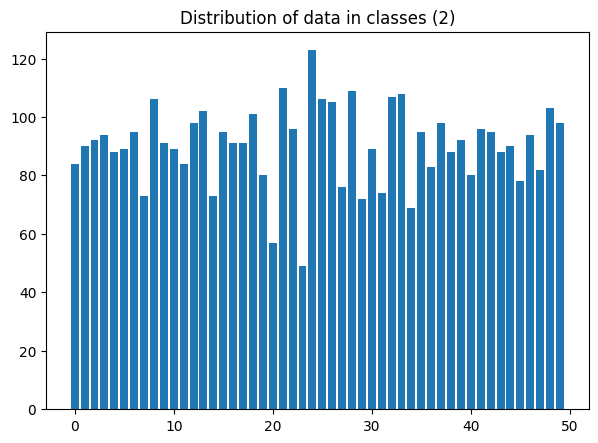

In [ ]:
plt.bar(indices,classes_hist_2)
plt.gca().set( title='Distribution of data in classes (2)')


(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500., 20000.]), <a list of 10 Text major ticklabel objects>)

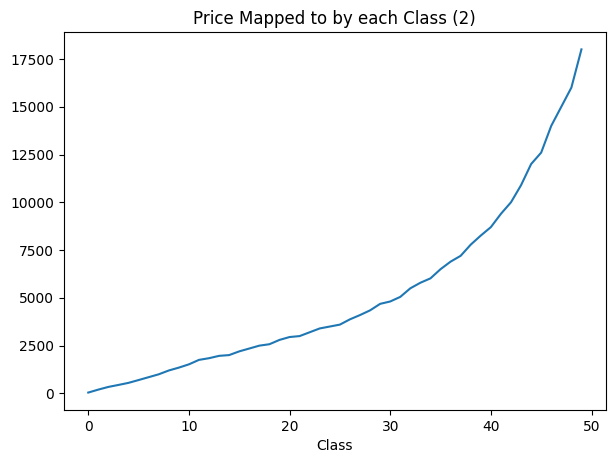

In [ ]:
classes_2['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price Mapped to by each Class (2)', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')
#plt.xlim([0, 20000])

In [ ]:
classes_2.to_csv('/content/drive/My Drive/CPEN 291/project/data/classes_50.csv')

### Making different numbers of classes

In [88]:
# Function to help make classes
def make_classes(labels, number):
  _classes = pd.DataFrame(columns=['price', 'index'])
  _sorted = labels.sort_values(by=['price'])
  _sorted = _sorted.reset_index()
  _last_one = 0
  _add_amt = 35
  if (number > 100):
    _add_amt = 10
  for i in range(0, number):
    _index = math.floor(float(i)/number * _sorted['price'].size)
    _class_ = _sorted['price'][_index]
    # This step prevents the difference of two classes from being too small
    # + 35 seems to yield the lowest SD (see classes bar graph below)
    while (_class_ <= _last_one + _add_amt): 
      _index += 1
      _class_ = _sorted['price'][_index]
    _last_one = _class_
    _classes = _classes.append({'price' : _class_, 'index': _index}, ignore_index=True)

  _classes_hist = np.zeros(number)
  _indices = np.zeros(number)
  for i in range(1, number):
    _indices[i] = _indices[i - 1] + 1
  
  for p in labels['price']:
    for i in range(0, number-1):
      if (p >= _classes['price'][i] and p < _classes['price'][i + 1]): 
        _classes_hist[i] += 1
        break
    if (p >= _classes['price'][number-1]):
      _classes_hist[number-1] += 1
      
  _classes_2 = _classes.copy()
  for i in range (0, number-2):
    if (_classes_hist[i] * 1.3 < _classes_hist[i+1]):
      _classes_2['index'][i+1] = math.floor(_classes['index'][i+1] + (_classes['index'][i+2] - _classes['index'][i+1]) * 1/5)
      _classes_2['price'][i+1] = _sorted['price'][_classes_2['index'][i+1]]

  return _classes_2


In [80]:
def analyze_classes(labels, classes, number):
  _ch = np.zeros(number)
  _indices = np.zeros(number)
  for i in range(1, number):
    _indices[i] = _indices[i - 1] + 1
  
  for p in labels['price']:
    for i in range(0, number-1):
      if (p >= classes['price'][i] and p < classes['price'][i + 1]): 
        _ch[i] += 1
        break
    if (p >= classes['price'][number-1]):
      _ch[number-1] += 1
  
  
  print(_ch)
  print(_ch.sum())
  print(f"""
  Average: {np.average(_ch)}
  Variance: {np.var(_ch)}
  SD: {np.std(_ch)}
  Median: {np.median(_ch)}
  Max: {np.max(_ch)}
  Min: {np.min(_ch)}
  """)
  plt.bar(_indices,_ch, width=7)
  plt.gca().set( title='Distribution of data in '+ str(number) + ' classes ')


In [ ]:
classes_100 = make_classes(labels=labels, number=100)

In [ ]:
print(classes_100)

In [ ]:
classes_100.to_csv('/content/drive/My Drive/CPEN 291/project/data/classes_100.csv')


[54. 30. 48. 42. 51. 51. 44. 40. 42. 46. 48. 41. 50. 45. 45. 28. 64. 42.
 47. 61. 33. 39. 37. 47. 37. 72. 91. 12. 31. 30. 48. 47. 39. 52. 84. 13.
 48. 22. 60. 45. 57. 72. 10. 28. 53. 43. 49. 96. 22. 34. 32. 45. 34. 68.
 28. 51. 40. 56. 49. 36. 39. 50. 44. 30. 57. 50. 30. 29. 78. 40. 50. 45.
  8. 75. 32. 66. 25. 63. 38. 54. 54. 26. 55. 41. 51. 44. 41. 47. 58. 44.
 36. 30. 58. 36. 49. 33. 61. 42. 52. 46.]
4516.0

  Average: 45.16
  Variance: 242.05440000000002
  SD: 15.558097570075848
  Median: 45.0
  Max: 96.0
  Min: 8.0
  


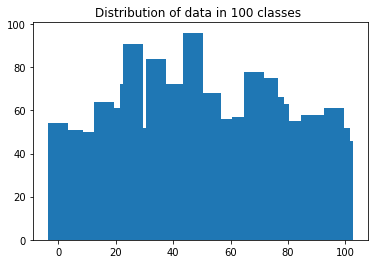

In [ ]:
analyze_classes(labels=labels, classes=classes_100, number=100)

(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500., 20000.]), <a list of 10 Text major ticklabel objects>)

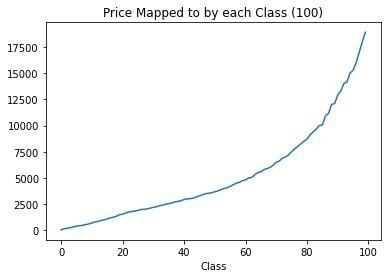

In [ ]:
classes_100['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price Mapped to by each Class (100)', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


In [ ]:
classes_30 = make_classes(labels=labels, number=30)

In [ ]:
print(classes_30)

       price   index
0      45.00     0.0
1     293.65   150.0
2     458.09   301.0
3     700.00   451.0
4     950.00   602.0
5    1210.00   752.0
6    1521.11   903.0
7    1800.00  1053.0
8    2000.00  1204.0
9    2200.00  1354.0
10   2400.00  1505.0
11   2695.00  1655.0
12   2950.00  1806.0
13   3100.00  1956.0
14   3495.00  2107.0
15   3600.00  2258.0
16   4000.00  2408.0
17   4484.00  2559.0
18   4810.00  2709.0
19   5400.00  2860.0
20   5900.00  3010.0
21   6500.00  3161.0
22   7040.00  3311.0
23   8000.00  3462.0
24   8700.00  3612.0
25   9800.00  3763.0
26  11000.00  3913.0
27  12600.00  4064.0
28  14500.00  4214.0
29  16544.63  4365.0


In [ ]:
classes_30.to_csv('/content/drive/My Drive/CPEN 291/project/data/classes_30.csv')


[143. 157. 148. 141. 163. 150. 126. 156. 164. 134. 173. 151. 149. 152.
 134. 140. 178. 150. 142. 158. 147. 155. 146. 155. 141. 143. 165. 150.
 150. 155.]
4516.0

  Average: 150.53333333333333
  Variance: 122.18222222222222
  SD: 11.053606751744981
  Median: 150.0
  Max: 178.0
  Min: 126.0
  


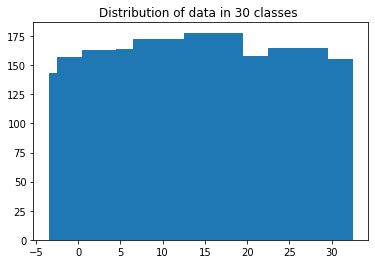

In [ ]:
analyze_classes(labels=labels, classes=classes_30, number=30)

(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500.]), <a list of 9 Text major ticklabel objects>)

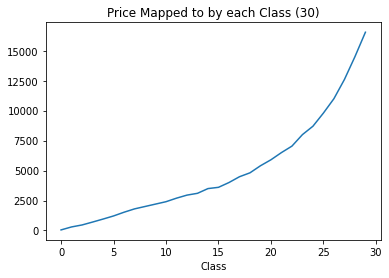

In [ ]:
classes_30['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price Mapped to by each Class (30)', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


In [ ]:
classes_75 = make_classes(labels=labels, number=75)

In [ ]:
print(classes_75)

       price   index
0      45.00     0.0
1     176.19    60.0
2     234.92   120.0
3     340.63   180.0
4     421.00   252.0
..       ...     ...
70  14500.00  4214.0
71  15034.88  4275.0
72  16326.94  4347.0
73  17500.00  4395.0
74  18600.00  4455.0

[75 rows x 2 columns]


In [ ]:
classes_75.to_csv('/content/drive/My Drive/CPEN 291/project/data/classes_75.csv')


[60. 58. 56. 76. 50. 60. 57. 55. 65. 77. 48. 43. 76. 61. 60. 61. 59. 53.
 81. 28. 97. 40. 75. 47. 74. 17. 91. 56. 75. 50. 57. 74. 36. 68. 77. 96.
 27. 43. 63. 34. 82. 65. 40. 81. 60. 39. 82. 42. 87. 50. 29. 88. 76. 49.
 60. 55. 66. 71. 36. 73. 58. 75. 43. 64. 72. 47. 63. 43. 62. 72. 64. 72.
 45. 63. 61.]
4516.0

  Average: 60.21333333333333
  Variance: 281.2611555555556
  SD: 16.770842422357788
  Median: 60.0
  Max: 97.0
  Min: 17.0
  


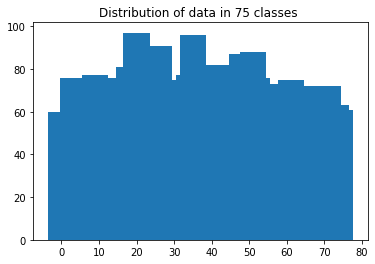

In [ ]:
analyze_classes(labels=labels, classes=classes_75, number=75)

(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500., 20000.]), <a list of 10 Text major ticklabel objects>)

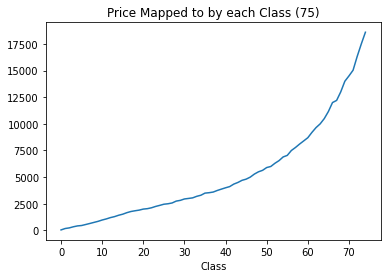

In [ ]:
classes_75['price'].plot()
plt.gca().set( facecolor='w')
plt.gca().set( title='Price Mapped to by each Class (75)', facecolor='w')
plt.xlabel('Class', color='k')
plt.xticks(color='k')
plt.yticks(color='k')


In [8]:
classes_2 = make_classes(labels=labels, number=2)

In [11]:
classes_2.to_csv('/content/drive/My Drive/CPEN 291/project/data/classes_2.csv')


In [12]:
classes_4 = make_classes(labels=labels, number=4)

In [13]:
classes_4.to_csv('/content/drive/My Drive/CPEN 291/project/data/classes_4.csv')


In [14]:
classes_8 = make_classes(labels=labels, number=8)
classes_8.to_csv('/content/drive/My Drive/CPEN 291/project/data/classes_8.csv')
classes_16 = make_classes(labels=labels, number=16)
classes_16.to_csv('/content/drive/My Drive/CPEN 291/project/data/classes_16.csv')

In [ ]:
analyze_classes(labels, classes_16, 16)

[28. 32. 36. 22. 25. 31. 34. 38. 20. 34. 30. 30. 29. 28. 31. 24. 25. 40.
 32. 20. 43. 30. 30. 13. 49. 27. 30. 31. 16. 44. 28. 33. 28. 31.  6. 47.
 37. 46. 15. 11. 92.  5. 11. 29. 27. 37. 36. 22. 22. 17. 52. 82.  2. 13.
 24. 26. 45. 28. 23. 29. 51.  6. 70.  4. 18. 18. 33. 35. 28. 49. 84.  4.
  9. 12. 37. 20. 26. 37. 34. 66.  5. 22. 23. 31. 31.  9. 56. 25. 25. 35.
 24. 15. 50. 32. 21. 21. 49.  8. 50. 30. 29. 49. 17. 22. 30. 46. 24. 25.
  8. 52. 35. 20. 40. 26. 25. 45. 18. 19. 19. 54. 30. 28. 22. 47. 14. 35.
 50. 16. 29. 35. 25. 28. 58. 11. 21. 16. 46. 16. 49. 23. 22. 42. 29. 11.
 46. 31. 26. 37. 29. 32.]
4516.0

  Average: 30.106666666666666
  Variance: 233.8552888888889
  SD: 15.292327778624447
  Median: 29.0
  Max: 92.0
  Min: 2.0
  


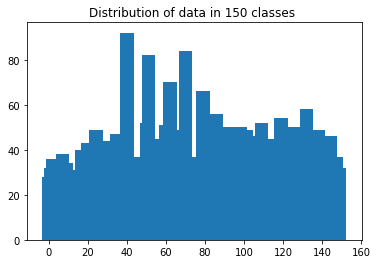

In [91]:
classes_150 = make_classes(labels=labels, number=150)
classes_150.to_csv('/content/drive/My Drive/CPEN 291/project/data/classes_150.csv')
analyze_classes(labels, classes_150, 150)

[28. 44. 32. 39. 50. 32. 38. 37. 37. 39. 36. 36. 41. 36. 39. 25. 43. 45.
 28. 49. 35. 31. 38. 44. 38. 38. 27. 23. 62. 22. 50. 22. 92.  8. 37. 27.
 43. 33. 41. 17. 52. 82.  9. 30. 26. 45. 41. 39. 51.  6. 70. 22. 18. 53.
 43. 49. 84.  4. 21. 37. 20. 49. 35. 13. 66. 30. 36. 46.  9. 64. 42. 35.
 39. 48. 33. 22. 21. 57. 43. 37. 29. 49. 34. 35. 46. 38. 19. 52. 35. 20.
 55. 36. 45. 34. 22. 54. 33. 41. 32. 35. 35. 50. 37. 43. 33. 20. 58. 32.
 48. 30. 49. 23. 22. 49. 33. 46. 40. 36. 41. 38.]
4516.0

  Average: 37.63333333333333
  Variance: 213.86555555555557
  SD: 14.624142899861024
  Median: 37.0
  Max: 92.0
  Min: 4.0
  


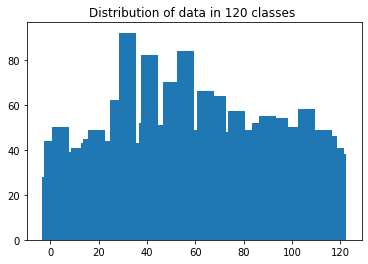

In [92]:
classes_120 = make_classes(labels=labels, number=120)
classes_120.to_csv('/content/drive/My Drive/CPEN 291/project/data/classes_120.csv')
analyze_classes(labels, classes_120, 120)


## Model

In [1]:
import torch, torchvision, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torchvision.transforms as transforms, torchvision.models as models
import matplotlib.pyplot as plt
import PIL, IPython
import pathlib
import pandas as pd
import math
import random
from tqdm.auto import tqdm
from collections import OrderedDict
#plt.style.use('dark_background')
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda')

In [4]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [93]:
classes = pd.read_csv(dataset_dir + 'classes_75.csv')
 

In [94]:
labels = pd.read_csv(dataset_dir + 'all_labels.csv')

In [95]:
class PriceClassificationDataset:
    def __init__(self, root_dir, use_random=False, transform=None, transform_label=None):

        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label

        self.classes = pd.read_csv(root_dir / 'classes_75.csv')

        if (use_random):
          self.labels_f = pd.read_csv(root_dir / 'all_labels_random.csv')
        else:
          self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')

        def get_class(p):
          if (p >= classes['price'][74]):
              return 74
          for i in range(0, len(classes['price'])-1):
            if (p >= self.classes['price'][i] and p < self.classes['price'][i + 1]): 
              return i

        def get_price(fn):
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            index = row.index[0]
            return row['price'][index]

        self.fns_labels = [(imgfn, get_class(get_price(imgfn)))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = PIL.Image.open(imgfn)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, label)

In [96]:
# Modified from object_detection.ipynb
def show_img_price(sample):
    img, class_ = sample
    price = classes['price'][class_]
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(price, color='black') # add color='w' arg if using a dark background
    plt.axis('off')

In [97]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()])
dataset_full = PriceClassificationDataset(dataset_dir, use_random=False, transform=xform)
len(dataset_full)

4498

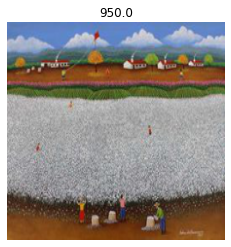

In [26]:
show_img_price(dataset_full[10])

In [98]:
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(291)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)
len(dataset_train), len(dataset_test)

(3598, 900)

In [99]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

In [100]:
def run_test(model, criterion, no_mispreds=False):
    nsamples_test = len(dataset_test)
    loss, correct = 0, 0
    model.eval()
    mispreds = []
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device)
            outs = model(samples)
            loss += criterion(outs, labels)
            _, preds = torch.max(outs.detach(), 1) # pick highest-score class
            correct += (preds == labels).sum(0).item()
            if not no_mispreds:
                mispreds += [(s, p, l) for s, p, l in zip(samples.unbind(), preds, labels) if p != l]
    return loss / nsamples_test, correct / nsamples_test, mispreds

def run_train(model, criterion, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar, correct_sofar = 0, 0
    model.train()
    with torch.enable_grad():
        # tqdm = pretty progress bar
        for samples, labels in tqdm(loader_train, desc='iters', leave=False):
            samples = samples.to(device)
            labels = labels.to(device)
            opt.zero_grad()
            outs = model(samples)
            _, preds = torch.max(outs.detach(), 1) # pick highest-score class
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            correct_sofar += torch.sum(preds == labels.detach())
    sched.step()
    return loss_sofar / nsamples_train, correct_sofar / nsamples_train

def run_all(model, criterion, optimizer, scheduler, n_epochs):
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train, acc_train = run_train(model, criterion, optimizer, scheduler)
        loss_test, acc_test, _ = run_test(model, criterion, no_mispreds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")
    return loss_test, acc_test

In [103]:
model = torchvision.models.resnet34(pretrained=True)

trim = False
# from https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
if (trim):
  model.layer3 = Identity();
  model.layer4 = Identity();

model.fc = torch.nn.Linear(model.fc.in_features, len(dataset_full.classes))
#model.fc = torch.nn.Linear(128, len(dataset_full.classes))
torch.nn.init.xavier_uniform_(model.fc.weight)

model.to(device);

In [104]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
loss_test, acc_test, _ = run_test(model, criterion, no_mispreds=True)
loss_test, acc_test

In [105]:
run_all(model, criterion, optimizer, scheduler, 10)

epoch 1: train loss 4.6536 acc 0.0245, test loss 0.1396 acc 0.0422


epoch 2: train loss 3.6849 acc 0.1732, test loss 0.1349 acc 0.0644


epoch 3: train loss 3.3993 acc 0.3499, test loss 0.1342 acc 0.0733


epoch 4: train loss 3.1589 acc 0.5878, test loss 0.1334 acc 0.0933


epoch 5: train loss 3.1177 acc 0.6220, test loss 0.1335 acc 0.0967


epoch 6: train loss 3.1029 acc 0.6534, test loss 0.1334 acc 0.0956


epoch 7: train loss 3.0757 acc 0.6665, test loss 0.1338 acc 0.0989


epoch 8: train loss 3.0715 acc 0.6793, test loss 0.1333 acc 0.1000


epoch 9: train loss 3.0734 acc 0.6684, test loss 0.1334 acc 0.0922


epoch 10: train loss 3.0636 acc 0.6732, test loss 0.1333 acc 0.0922



(tensor(0.1333, device='cuda:0'), 0.09222222222222222)

model | no. of classes |epochs| crit | optim | sched | train loss | train acc | test loss | test acc | MESLoss (see below) | saved
--- | --- | --- | --- |--- |--- |--- | --- | ---| ---|---| ---
resnet18, fc=1 linear | 2 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 0.10| 0.99| 0.024| 0.62 | | yes
resnet34, fc=1 linear | 2 |3 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 0.30| 0.89| 0.025| 0.59 | | 
resnet34, fc=1 linear | 2 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.3 | StepLR, ss=3, g=0.1| 0.09| 0.99| 0.024| 0.62 | | 
resnet34, fc=1 linear | 2 |10 | CrossEntropy | SGD, lr=0.0005, m=0.9, wd=0.5 | StepLR, ss=3, g=0.1| 0.28| 0.96| 0.0221| 0.6178| | 
resnet18, fc=1 linear | 4 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 0.52| 0.93| 0.043| 0.40| | 
resnet18, fc=1 linear | 4 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 0.21| 0.99| 0.045| 0.40| | yes
resnet34, fc=1 linear | 4 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 0.09| 0.99| 0.025| 0.63*| could not | replicate
resnet18, fc=1 linear | 8 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 1.08| 0.85| 0.0632| 0.26| | yes
resnet34, fc=1 linear | 8 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 0.55| 0.97| 0.0638| 0.27| | 
resnet34, fc=1 linear | 8 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 0.59| 0.97| 0.0655| 0.26| | 
resnet34, fc=1 linear | 8 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.3 | StepLR, ss=3, g=0.1| 1.23| 0.86| 0.0626| 0.26| | 
resnet34, fc=1 linear | 8 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.3 | StepLR, ss=3, g=0.1| 1.23| 0.86| 0.0626| 0.26| | 
resnet34, fc=1 linear | 16 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 1.24| 0.91| 0.085| 0.16| | 
resnet18, fc=1 linear | 16 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 1.72| 0.78| 0.085| 0.16| | yes
resnet34, fc=1 linear | 30 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 2.019 | 0.8413 | 0.1046 | 0.1233 | 1.12 | 
resnet18, fc=1 linear | 30 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 2.45 | 0.66 | 0.1044 | 0.118 |  | yes
resnet34, fc=1 linear | 30 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.3 | StepLR, ss=3, g=0.1| 2.59| 0.| 0.70| 0.105| 1.22| 
resnet18, fc=1 linear | 50 |10 | CrossEntropy | SGD, lr=0.001, m=0.9 | StepLR, ss=3, g=0.1| 1.49 | 0.8255 | 0.1277 | 0.0778 | 
resnet18, fc=1 linear | 50 |10| CrossEntropy | SGD, lr=0.001, m=0.9 | StepLR, ss=3, g=0.1| 1.57| 0.79 | 0.1288 | 0.09 | 1.02 | yes
resnet18, fc=1 linear | 50 |10| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.1 | StepLR, ss=3, g=0.1| 1.| 0.| 0.| 0.0778 | 
resnet18, fc=1 linear | 50 |10| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.1 | StepLR, ss=2, g=0.1| 2.67 | 0.52 | 0.123 | 0.08 | 
resnet18, fc=1 linear | 50 |10| CrossEntropy | SGD, lr=0.001, m=0.5, wd=0.1 | StepLR, ss=3, g=0.1| 3.3544| 0.1579| 0.1318 | 0.0467 | 
resnet18, fc=1 linear | 50 |10| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 3.0068| 0.5889| 0.1213| 0.0911|  | yes
resnet18, fc=1 linear | 50 |20| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 3.006| 0.59| 0.12| 0.09| 
resnet34, fc=1 linear | 50 |10| CrossEntropy | SGD, lr=0.001, m=0.9 | StepLR, ss=3, g=0.1| 0.9735 | 0.9316 | 0.1308 | 0.0778
resnet18, trimmed, fc=1 linear | 50 |10| CrossEntropy | SGD, lr=0.001, m=0.9 | StepLR, ss=3, g=0.1| 3.91 | 0.026| 0.126| 0.021
resnet18, fc=1 linear | 50 |20| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 3.006| 0.59| 0.12| 0.09| 
resnet34, fc=1 linear | 75 |10| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 3.094| 0.6812| 0.1326| 0.0833| 1.22 | 
resnet18, fc=1 linear | 75 |10| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 3.06| 0.6732| 0.1333| 0.922|  | yes
resnet18, fc=1 linear | 100 |10| CrossEntropy | SGD, lr=0.001, m=0.9 | StepLR, ss=3, g=0.1| 2.07| 0.7143| 0.1498 | 0.074 | 1.09 | yes
resnet18, fc=1 linear | 100 |10| CrossEntropy | SGD, lr=0.001, m=0.9 | StepLR, ss=3, g=0.1| 3.02| 0.58| 0.14 | 0.077 | 
resnet34, fc=1 linear | 100 |10| CrossEntropy | SGD, lr=0.001, m=0.9 | StepLR, ss=3, g=0.1| 2.46| 0.79| 0.142| 0.088| 1.0029 | yes
resnet34, fc=1 linear | 100 |10| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 3.38| 0.55| 0.14| 0.069|  | 
resnet18, fc=1 linear | 100 |10| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 3.71| 0.38| 0.14| 0.066| 

In [106]:
torch.save(model.state_dict(), '/content/drive/My Drive/CPEN 291/project/model_jared_3_resnet18_75_wd02_10iter.pth')
torch.save(optimizer.state_dict(), '/content/drive/My Drive/CPEN 291/project/optim_jared_3_resnet18_75_wd02_10iter.pth')

In [ ]:
test_loss, test_preds, mis_preds = run_test(model, criterion)
print(test_loss)

tensor(0.1300, device='cuda:0')


In [ ]:
test_preds

0.08666666666666667

In [ ]:
mis_preds

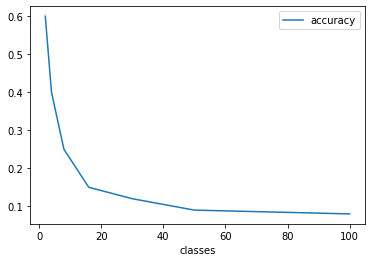

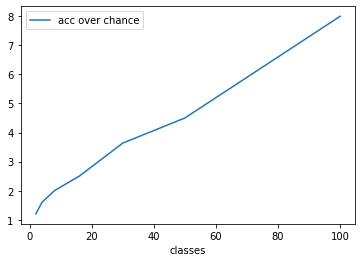

In [78]:
cls_acc_data = [[2, 0.6, 0.5, 0.6/0.5], [4, 0.4, 0.25, 0.4/0.25], [8, 0.25, 0.125, 0.25/0.125], [16, 0.15, 0.06, 0.15/0.06], [30, 0.12, 0.033, 0.12/0.033], [50, 0.09, 0.02, 0.09/0.02], [100, 0.08, 0.01, 0.08/0.01]]
cls_acc = pd.DataFrame(cls_acc_data, columns=['classes', 'accuracy', 'random chance', 'acc over chance'])
cls_acc.plot(x="classes", y="accuracy", kind="line")
cls_acc.plot(x="classes", y="acc over chance", kind="line")

## How does it stack up against the other models?

The accuracy is far from good... But where does it stand among all models?

As shown below, the test loss is quite a bit better than training a model that outputs continuous values. 

In [39]:
model.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/model_jared_3_resnet18_30_wd02_10iter.pth'))

<All keys matched successfully>

In [40]:
# wrapper class for comparison
# untrainable, only for demo
class wrapper(nn.Module):
    def __init__(self):
        super(wrapper, self).__init__()
        self.model = model

    def forward(self, x):
        x = self.model(x)
        _, pred = torch.max(x.detach(), 1) # pick highest-score class
        for i in range(pred.size()[0]):
          if (pred[i].item() < 29):
            pred[i] = math.log(classes['price'][pred[i].item()] + (classes['price'][pred[i].item()+1] - classes['price'][pred[i].item()]) * (1/random.uniform(1.2, 3)))
          else:
            pred[i] = math.log(classes['price'][pred[i].item()] + (20000 - classes['price'][pred[i].item()]) * (1/random.uniform(1.2, 3)))
        return pred.unsqueeze(1)

def run_test_2(model, criterion, no_preds=False):
    nsamples_test = len(dataset_test2)
    loss = 0
    preds = []
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test2:
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outs = model(samples)
            if not no_preds:
                preds += outs.cpu().unbind()
            loss += criterion(outs, labels) * samples.size(0)
    return loss / nsamples_test, preds

In [41]:
# Modified from object_detection.ipynb
class PricePredictionDataset:
    def __init__(self, root_dir, use_random=False, transform=None, transform_label=None):
        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label

        if (use_random):
          self.labels_f = pd.read_csv(root_dir / 'all_labels_random.csv')
        else:
          self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')

        def get_price(fn):
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            index = row.index[0]
            return math.log(row['price'][index]) # log because we are scientists

        self.fns_labels = [(imgfn, get_price(imgfn))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = PIL.Image.open(imgfn)
        if (len(img.split()) > 3): # some images have one more channel
          r,g,b, _ = img.split()
          img = PIL.Image.merge('RGB', (r,g,b))
        if (len(img.split()) == 1): # some images only have one channel
          img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, label)

In [42]:
dataset_full2= PricePredictionDataset(dataset_dir, False, transform=xform)

In [43]:
n_all= len(dataset_full2)
n_used= int(1 * n_all)
n_train= int(0.8 * n_used)
n_test= n_used- n_train
rng= torch.Generator().manual_seed(1910)
dataset_train2, dataset_test2, _ = torch.utils.data.random_split(dataset_full2, [n_train, n_test, n_all-n_train-n_test], rng)
len(dataset_train2), len(dataset_test2)

(3598, 900)

In [44]:
loader_train2 = torch.utils.data.DataLoader(dataset_train2, batch_size=32, shuffle=False)
loader_test2 = torch.utils.data.DataLoader(dataset_test2, batch_size=32, shuffle=False)

In [45]:
criterion2 = torch.nn.MSELoss()

In [46]:
w = wrapper()
test_loss, test_preds= run_test_2(w, criterion2)
print(test_loss)

tensor(1.1210, device='cuda:0')


In [ ]:
test_loss

tensor(1.0029, device='cuda:0')

In [ ]:
# Modified from object_detection.ipynb
def show_img_price2(sample):
    img, price = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(math.e**price, color='black') # add color='w' arg if using a dark background
    plt.axis('off')

Prediction     | Real Price


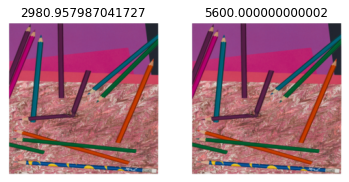

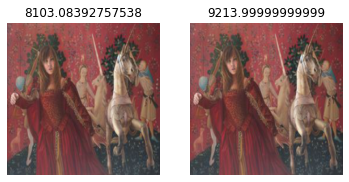

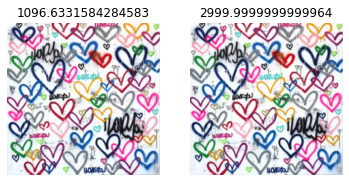

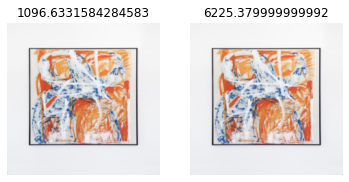

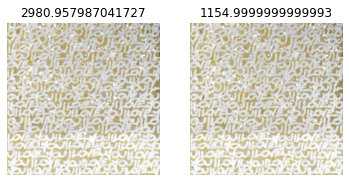

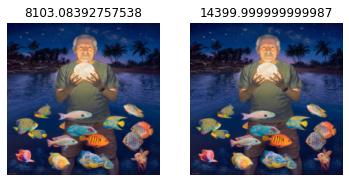

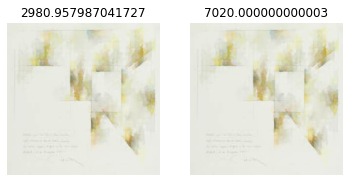

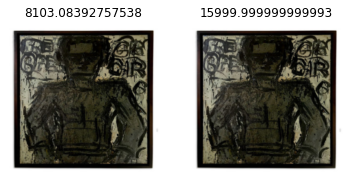

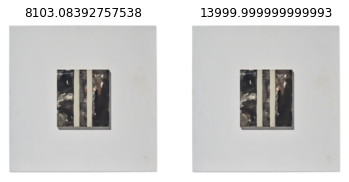

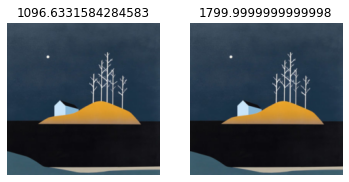

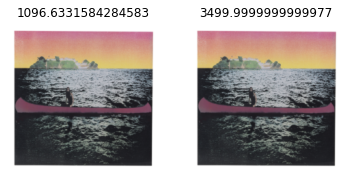

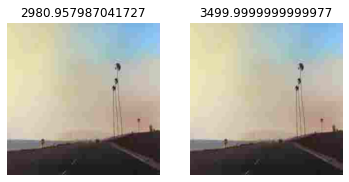

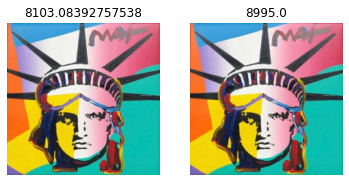

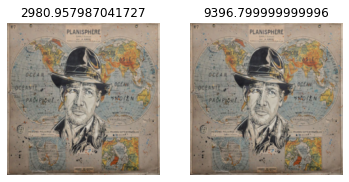

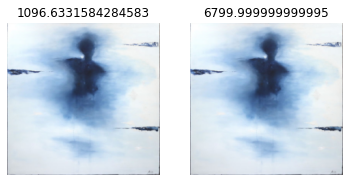

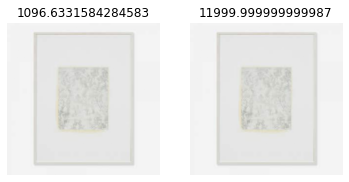

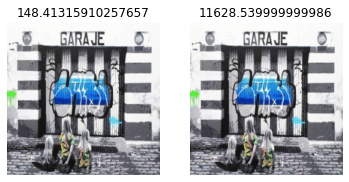

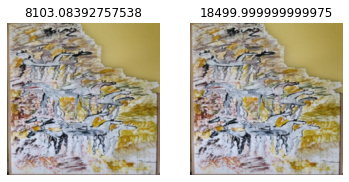

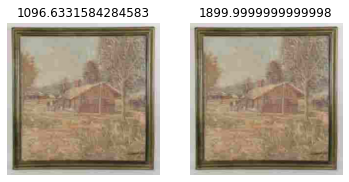

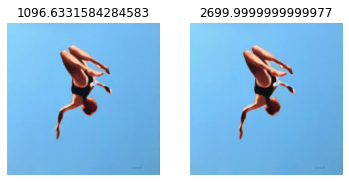

In [ ]:
print("Prediction     | Real Price")
for i in range(20):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    show_img_price2((dataset_test2[i][0], test_preds[i].item()))
    f.add_subplot(1,2, 2)
    show_img_price2(dataset_test2[i])
    plt.show(block=True)
